## **1. Importações**

In [11]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    classification_report
)

## **2. Carregar modelo e dados**

In [12]:
best_rf = joblib.load("../models/best_random_forest.pkl")

X_test = joblib.load("../data/processed/X_test.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

## **3. Probabilidades de churn**

In [13]:
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ROC-AUC: 0.8429748364977765


## **4. Avaliação por múltiplos thresholds**

In [14]:
thresholds = np.arange(0.1, 0.9, 0.05)

metricas = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    metricas.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t)
    })

df_metricas = pd.DataFrame(metricas)
df_metricas

,threshold,precision,recall,f1
0,0.10,0.329069,0.991435,0.494130
1,0.15,0.352806,0.982869,0.519231
2,0.20,0.369243,0.961456,0.533571
3,0.25,0.394454,0.944325,0.556467
4,0.30,0.416749,0.905782,0.570850
5,0.35,0.435233,0.899358,0.586592
6,0.40,0.453744,0.882227,0.599273
7,0.45,0.482843,0.843683,0.614186
8,0.50,0.520661,0.809422,0.633697
9,0.55,0.559295,0.747323,0.639780


## **5. Curva Precision–Recall**

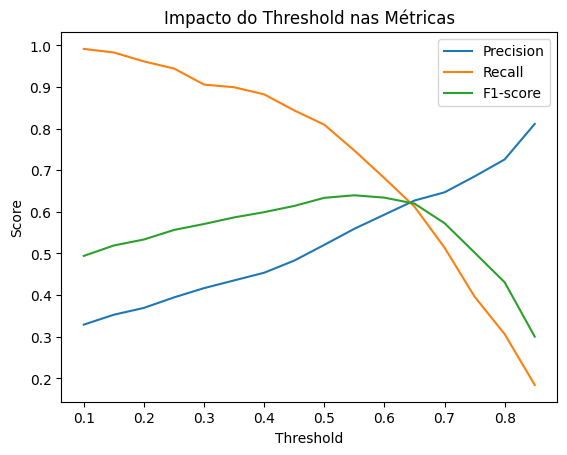

In [15]:
plt.figure()
plt.plot(df_metricas["threshold"], df_metricas["precision"], label="Precision")
plt.plot(df_metricas["threshold"], df_metricas["recall"], label="Recall")
plt.plot(df_metricas["threshold"], df_metricas["f1"], label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Impacto do Threshold nas Métricas")
plt.show()

## **6. Curva de Custo (NEGÓCIO)**

### 6.1 Definição de custos (exemplo realista)

In [16]:
custo_fp = 1     # oferecer benefício para quem não iria churnar
custo_fn = 10    # perder cliente churn (muito mais caro)

### 6.2 Cálculo de custo total

In [17]:
custos = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    custo_total = (fp * custo_fp) + (fn * custo_fn)

    custos.append({
        "threshold": t,
        "custo_total": custo_total,
        "fp": fp,
        "fn": fn
    })

df_custos = pd.DataFrame(custos)
df_custos

,threshold,custo_total,fp,fn
0,0.10,984,944,4
1,0.15,922,842,8
2,0.20,947,767,18
3,0.25,937,677,26
4,0.30,1032,592,44
5,0.35,1015,545,47
6,0.40,1046,496,55
7,0.45,1152,422,73
8,0.50,1238,348,89
9,0.55,1455,275,118


## **7. Curva de custo**

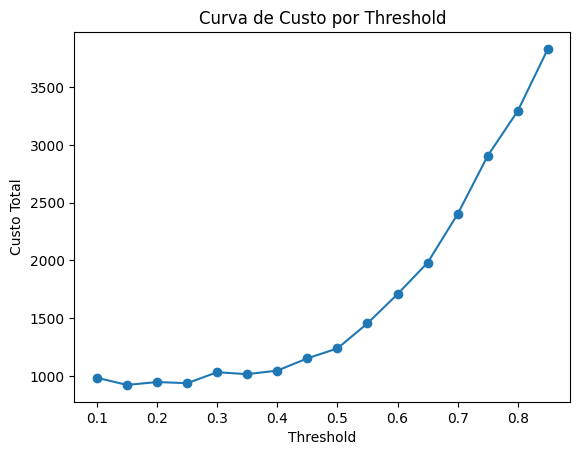

In [18]:
plt.figure()
plt.plot(df_custos["threshold"], df_custos["custo_total"], marker='o')
plt.xlabel("Threshold")
plt.ylabel("Custo Total")
plt.title("Curva de Custo por Threshold")
plt.show()

## **8. Threshold ótimo (mínimo custo)**

In [19]:
threshold_otimo = df_custos.loc[
    df_custos["custo_total"].idxmin(),
    "threshold"
]

threshold_otimo

np.float64(0.15000000000000002)

## **9. Avaliação final com threshold ajustado**

In [20]:
y_pred_final = (y_proba >= threshold_otimo).astype(int)

print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.98      0.35      0.51      1291
           1       0.35      0.98      0.52       467

    accuracy                           0.52      1758
   macro avg       0.67      0.67      0.52      1758
weighted avg       0.82      0.52      0.52      1758



## Conclusão

A análise de múltiplos thresholds demonstrou que o valor ótimo do ponto de corte,
do ponto de vista estritamente financeiro, foi **0.15**, resultado de um cenário
em que o custo de perder um cliente (falso negativo) é significativamente superior
ao custo de uma ação de retenção desnecessária (falso positivo).

Entretanto, operar com um threshold tão baixo implicaria classificar um volume
muito elevado de clientes como em risco, tornando a estratégia operacionalmente
inviável e diluindo os esforços de retenção.

Dessa forma, optou-se por separar o **threshold analítico** do **threshold operacional**.
Embora o threshold ótimo por custo tenha sido 0.15, adotamos um threshold operacional
mais conservador (**0.30**), equilibrando eficiência do modelo, capacidade de atuação
do negócio e priorização de clientes com maior risco.

Essa decisão permite que o modelo seja utilizado como um sistema de suporte à decisão,
com foco em ações de retenção mais assertivas. A operacionalização final do churn é
realizada por meio de **faixas de risco**, utilizadas no processo de predição em lote
e nos dashboards executivos, conforme detalhado nas etapas seguintes do projeto.